In [1]:
# from utils import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.sparse as sp
from scipy.constants import hbar, e, m_e, h
from types import SimpleNamespace
import tinyarray
import time

/home/khaled-hasan/myenv/lib/python3.12/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
def binary_search(array, value):
    l, r = 0, len(array) - 1
    while l <= r:
        mid = (l + r) // 2
        if array[mid] < value:
            l = mid + 1
        elif array[mid] > value:
            r = mid - 1
        else:
            return mid
    return l  # Return the index where the value would be inserted

# Define a Haldane model

In [3]:
lat = kwant.lattice.honeycomb(a = 1.0, norbs=1)
a_lat, b_lat = lat.sublattices

nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def onsite(site, param):
    return param.m if site.family == a_lat else -param.m
def nn_hopping(site1, site2, param):
    # x1, y1 = site1.pos
    # x2, y2 = site2.pos
    # return -np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))
    return -1.0
def nnn_hopping(site1, site2, param):
    # x1, y1 = site1.pos
    # x2, y2 = site2.pos
    # return 1j*param.t_prime*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2)) + param.t2
    return param.t2

Lx, Ly = 20, 10
r = 5
# create system
sys = kwant.Builder()

# rectangle
# sys[lat.shape(lambda pos: 0<=pos[0]<Lx and 0<=pos[1]<Ly, start = (0, 0))] = onsite

# circle
# sys[lat.shape(lambda pos: 0<= pos[0]*pos[0] + pos[1]*pos[1] < r*r, start = (0, 0))] = onsite

# triangle
for i in range(0, Lx):
    for j in range(0, Lx-i):
        sys[a_lat(i, j)] = onsite
        sys[b_lat(i, j)] = onsite

# hexagon
# for i in range(0, 2*Lx):
#     if i < Lx:
#         for j in range(0, Lx):
#             sys[a_lat(i, j)] = onsite
#             sys[b_lat(i, j)] = onsite
#             if j > 0:
#                 sys[a_lat(i+j, -j)] = onsite
#                 sys[b_lat(i+j, -j)] = onsite
#     else:
#         for j in range(0, Lx - (i - Lx)):
#             sys[a_lat(i, j)] = onsite
#             sys[b_lat(i, j)] = onsite
#             if j > 0:
#                 sys[a_lat(i+j, -j)] = onsite
#                 sys[b_lat(i+j, -j)] = onsite

sys[lat.neighbors(n=1)] = nn_hopping

# Choose a specific site
sites = list(sys.sites())
# Count the number of connections (hopping terms) for the site
# make sure that no lattice point is connected to more than one site
for __ in range(2):
    sites = list(sys.sites())
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections == 1 or num_connections == 0: del sys[s]

sys[lat_neighbors_2] = nnn_hopping



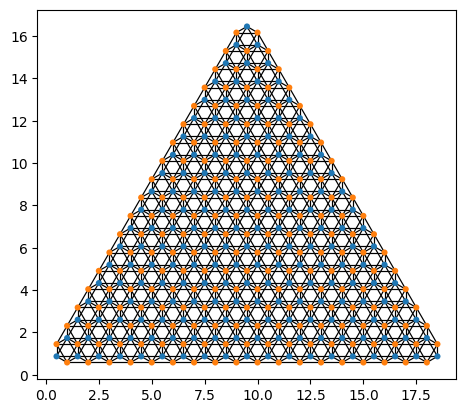

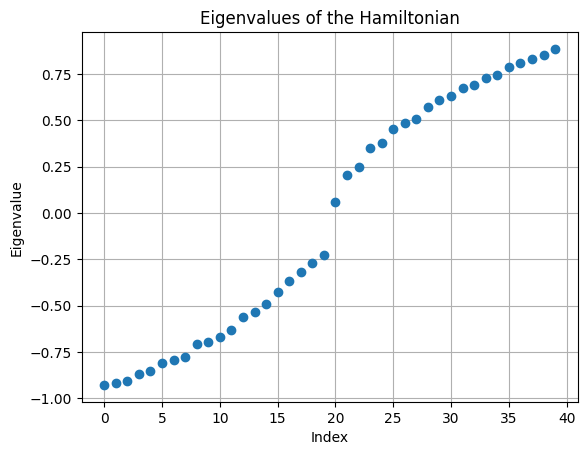

In [4]:
system_parameters = SimpleNamespace(m = 0.64, t2 = 0.15*np.exp(-1j*np.pi/3))
h = sys.finalized().hamiltonian_submatrix(sparse=False, params=dict(param=system_parameters))
N = len(h)
eigenvalues, eigenvectors = np.linalg.eigh(h)
eigenstates = eigenvectors.T
i_0 = binary_search(eigenvalues, 0.0)
kwant.plot(sys, show=False)
plt.show()
plt.plot(np.sort(eigenvalues)[i_0-40//2:i_0+40//2], 'o')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the Hamiltonian')
plt.grid()
plt.show()

## Bott index

In [5]:
botts = []
for m_ in np.linspace(0, 1.5, 26):
    system_parameters = SimpleNamespace(m=m_, B=0.0, t_prime=0.0, t2=0.15*np.exp(-1j*np.pi/3))
    h = sys.finalized().hamiltonian_submatrix(sparse=False, params=dict(param=system_parameters))
    N = len(h)
    eigenvalues, eigenvectors = np.linalg.eigh(h)
    eigenstates = eigenvectors.T
    # i_0 = binary_search(eigenvalues, 0.0)

    P = np.zeros([len(eigenstates[0]),len(eigenstates[0])], dtype=complex)
    N_occ = binary_search(eigenvalues, 0.0)
    for i in range(N//2 - 9):
        P += np.array([eigenstates[i]]).T@np.array([eigenstates[i].conj()])

    x_positions = np.array([s.pos[0] for s in sys.finalized().sites])
    x_norm = (x_positions-min(x_positions))/(max(x_positions)-min(x_positions))
    y_positions = np.array([s.pos[1] for s in sys.finalized().sites])
    y_norm = (y_positions-min(y_positions))/(max(y_positions)-min(y_positions))

    X = np.diag(x_norm)
    # X = np.diag(x_positions - min(x_positions))
    Y = np.diag(y_norm)
    # Y = np.diag(y_positions - min(y_positions))

    pXp = P@X@P
    pYp = P@Y@P

    U = la.expm(1j*2*np.pi*pXp)
    V = la.expm(1j*2*np.pi*pYp)
    UVUdVd = U@V@np.conj(U.T)@np.conj(V.T)
    bott = np.imag(np.sum(np.log(np.linalg.eigvals(UVUdVd))))/2/np.pi
    botts.append(bott)
    # bott = 2*np.pi*1j*np.trace(pXp@pYp - pYp@pXp)
    print("m", m_, ", Bott index:", bott)

m 0.0 , Bott index: -9.12127441394382e-16
m 0.06 , Bott index: 5.0846227020226335e-15
m 0.12 , Bott index: -7.939669845667174e-16
m 0.18 , Bott index: -7.377591719354129e-16
m 0.24 , Bott index: -3.360870396889009e-15
m 0.3 , Bott index: -8.151821439291789e-16
m 0.36 , Bott index: -4.699451480737252e-15
m 0.42 , Bott index: 4.2650787923686145e-15
m 0.48 , Bott index: -5.619591433055839e-15
m 0.54 , Bott index: 4.120252816669787e-15
m 0.6 , Bott index: -7.579360942460371e-16
m 0.6599999999999999 , Bott index: 4.529615264165549e-16
m 0.72 , Bott index: -4.708882901097942e-15
m 0.78 , Bott index: -6.908531169648998e-15
m 0.84 , Bott index: -3.272056401908519e-15
m 0.8999999999999999 , Bott index: -6.822904816050102e-16
m 0.96 , Bott index: 3.5221543393293683e-15
m 1.02 , Bott index: 2.9836353726539637e-15
m 1.08 , Bott index: -1.9961539632906642e-15
m 1.14 , Bott index: 6.073069778340796e-16
m 1.2 , Bott index: 8.047030415757795e-16
m 1.26 , Bott index: -1.2834100566066204e-15
m 1.3199999

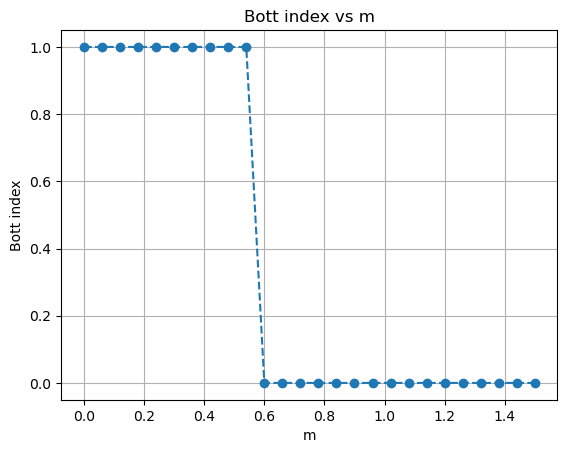

: 

In [ ]:
plt.plot(np.linspace(0, 1.5, 26), botts, 'o--')
plt.xlabel('m')
plt.ylabel('Bott index')
plt.title('Bott index vs m')
plt.grid()
# plt.savefig('bott_index_vs_m-rectangle-40x15.png')
plt.show()